# Asteroid Route Optimization


In [1]:
from imp import reload
import sys
import os
import os.path
from glob import glob
import numpy as np
import pandas as pd
# print(sys.version)
pd.show_versions()
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_style("whitegrid")
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    # Use Type 1 fonts in plots.
    "pdf.fonttype": 42,
}
plt.rcParams.update(tex_fonts)
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)

from arp_vis import get_fig_size


INSTALLED VERSIONS
------------------
commit           : 945c9ed766a61c7d2c0a7cbb251b6edebf9cb7d5
python           : 3.8.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.8.0-41-generic
Version          : #46~20.04.1-Ubuntu SMP Mon Jan 18 17:52:23 UTC 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_GB.UTF-8
LOCALE           : en_GB.UTF-8

pandas           : 1.3.4
numpy            : 1.20.3
pytz             : 2019.3
dateutil         : 2.7.3
pip              : 20.0.2
setuptools       : 45.2.0
Cython           : 3.0a6
pytest           : 4.6.9
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.5.0
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10.1
IPython          : 7.13.0
pandas_datareader: None
bs4              : 4.8.2
bottleneck       : None
f

In [2]:
#dfbest = pd.read_csv('best_fitness_selected.csv',sep=';')
def get_opt(instpath):
    instance_name = instpath.split('/')[-1].replace('.dat','').replace('.txt','')
    sol = dfbest[dfbest.instance_name==instance_name]
    if len(sol) != 1: 
        print("No opt value")
        return np.nan
    if sol.best_known_subdiagonal.isna().bool():
        return sol.best_known.iloc[0]
    else:
        return sol.best_known_subdiagonal.iloc[0]

def read_alldata(pat="./results/**/*.csv.xz"):
    lis = []
    for filename in glob(pat, recursive=True):
        if "greedynn-energy" in filename:
            continue
        tmp = pd.read_csv(filename)
        print(filename)
        #tmp.instance = tmp.instance.str.replace('pfsp/','pfsp_cmax/')
        if "dist_hamming" in filename:
            tmp['Distance'] = "hamming"
        elif "dist_kendall" in filename:
            tmp['Distance'] = "kendall"
        if "umm2" in filename:
             tmp['Solver'] = "UMM2"
        if "-er0" in filename:
            tmp['Solver'] += "_rank"
        elif "-er1" in filename:
            tmp['Solver'] += "_order"
        if "greedynn-euclidean" in filename:
            tmp['Solver'] = "GreedyNN"
        if "greedy_euclidean" in filename:
            tmp['Solver'] += "_greedy"
        #tmp['Solver'] += '_'
        #tmp['Solver'] += tmp.budget.astype(str)
        lis.append(tmp)
    df = pd.concat(lis, sort = True)
    # Fix instance names
    df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
    df['Instance'] = df['Instance'].str.replace('.txt','', regex=False).str.replace('.dat', '', regex=False)
    # Let's include the name just to be clear in the output.
    df['instance'] = 'ARP_' + df['instance']
    return df

def check_runs(df, nruns):
    # Some algorithms only have 1 run
    df = df[~df.Solver.str.startswith("GreedyNN")] 
    df2 = df.groupby(['Solver', 'instance','Distance',"eval_ranks","budget","Function evaluations"])['seed'].sum()
    totalruns = np.arange(1, nruns + 1).sum()
    assert (df2 == totalruns).all(),f"{df2[df2 != totalruns]}"
    assert (df.groupby(['Solver', 'instance','Distance',"eval_ranks","budget","Function evaluations"])['seed'].nunique() == nruns).all()

# If runs were terminated after different number of evaluations, 
# use only the evaluations reached in all runs to avoid misleading mean and variance.
def filter_unequal_budget(df, budget):
    groups = ['Solver','instance','eval_ranks','Distance']
    df_max_evals = df[df.Solver.str.startswith("CEGO")].groupby(groups + ['seed'])['Function evaluations'].max()
    df_max_evals = df_max_evals.groupby(groups).min()
    for index,row  in df_max_evals.reset_index().iterrows():
        if row['Function evaluations'] == budget: continue
        before = df.shape[0]
        # FIXME: How to do this in a shorter manner?
        df = df[~((df.Solver == row.Solver) & (df.instance == row.instance) & (df.eval_ranks == row.eval_ranks) & (df.Distance == row.Distance) & (df['Function evaluations'] > row['Function evaluations']))]
        print(f"Removed {before - df.shape[0]} rows for Solver={row.Solver} instance={row.instance} eval_ranks={row.eval_ranks} Distance={row.Distance}")
    return df

df = read_alldata()
# This is only for synthetic LOPs
#df['Uniformity'] = df.instance.str.extract(r'phi=(.+)$').astype(float)
# These are the instances used in the paper
sel_insts = []
if sel_insts:
    df = df[(mask) & (df.instance.isin(sel_insts))]
else:
    sel_insts = np.sort(df.instance.unique())
nruns = 5
df = filter_unequal_budget(df, 1000)
df['budget'].fillna(1,inplace=True)
df['seed'].fillna(1,inplace=True)
df['eval_ranks'].fillna(0,inplace=True)
df = df.sort_values(['Problem', 'instance', 'Solver', 'eval_ranks', 'budget','seed','Function evaluations'])
df['Best-so-far objective value'] = df.groupby(['Problem', 'instance','Solver', 'eval_ranks', 'budget','seed'])['Fitness'].cummin()
# Checks that make sure we have the correct number of runs
check_runs(df, nruns)
#df[df.Solver.str.startswith("GreedyNN")]

./results/m1-er0/arp_25_73/greedynn-euclidean.csv.xz
./results/m1-er0/arp_25_42/greedynn-euclidean.csv.xz
./results/m1-er0/arp_10_73/greedynn-euclidean.csv.xz
./results/m1-er0/arp_30_73/greedynn-euclidean.csv.xz
./results/m1-er0/arp_15_73/greedynn-euclidean.csv.xz
./results/m1-er0/arp_30_42/greedynn-euclidean.csv.xz
./results/m1-er0/arp_15_42/greedynn-euclidean.csv.xz
./results/m1-er0/arp_20_42/greedynn-euclidean.csv.xz
./results/m1-er0/arp_20_73/greedynn-euclidean.csv.xz
./results/m1-er0/arp_10_42/greedynn-euclidean.csv.xz
./results/m400-er1/arp_25_73/umm-maxmindist.csv.xz
./results/m400-er1/arp_25_73/cego-maxmindist.csv.xz
./results/m400-er1/arp_25_73/cego-greedy_euclidean.csv.xz
./results/m400-er1/arp_25_73/umm-greedy_euclidean.csv.xz
./results/m400-er1/arp_25_42/umm-maxmindist.csv.xz
./results/m400-er1/arp_25_42/cego-maxmindist.csv.xz
./results/m400-er1/arp_25_42/cego-greedy_euclidean.csv.xz
./results/m400-er1/arp_25_42/umm-greedy_euclidean.csv.xz
./results/m400-er1/arp_10_73/umm-m

In [3]:
df

,Distance,Fitness,Function evaluations,Problem,Solver,budget,budgetGA,distance,eval_ranks,init,...,phi_estim,phi_sample,ratio_samples_learn,rho,run_time,seed,weight_mass_learn,x,Instance,Best-so-far objective value
0,NaN,446.804799,1,ARP,CEGO_order,400,10000.0,NaN,1,maxmindist,...,NaN,NaN,NaN,NaN,140623.091583,1,NaN,8 3 6 0 1 4 2 9 5 7,10_42,446.804799
1,NaN,508.384154,2,ARP,CEGO_order,400,10000.0,NaN,1,maxmindist,...,NaN,NaN,NaN,NaN,140623.091583,1,NaN,7 4 9 1 2 5 6 0 3 8,10_42,446.804799
2,NaN,529.154279,3,ARP,CEGO_order,400,10000.0,NaN,1,maxmindist,...,NaN,NaN,NaN,NaN,140623.091583,1,NaN,7 8 5 9 3 0 1 4 2 6,10_42,446.804799
3,NaN,589.153896,4,ARP,CEGO_order,400,10000.0,NaN,1,maxmindist,...,NaN,NaN,NaN,NaN,140623.091583,1,NaN,5 2 3 1 0 4 9 8 7 6,10_42,446.804799
4,NaN,619.490589,5,ARP,CEGO_order,400,10000.0,NaN,1,maxmindist,...,NaN,NaN,NaN,NaN,140623.091583,1,NaN,9 4 6 8 3 5 7 2 0 1,10_42,446.804799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,NaN,1097.350579,396,ARP,UMM_rank_greedy,400,NaN,NaN,0,greedy_euclidean,...,NaN,0.09375,0.1,0.000003,4081.066453,30,0.9,5 9 13 2 28 25 1 11 14 19 23 3 21 17 18 20 27 ...,30_73,1024.711074
9596,NaN,1008.077441,397,ARP,UMM_rank_greedy,400,NaN,NaN,0,greedy_euclidean,...,NaN,0.09375,0.1,0.000003,4081.066453,30,0.9,5 9 13 2 27 25 1 11 14 19 23 3 21 17 18 20 28 ...,30_73,1008.077441
9597,NaN,1256.216039,398,ARP,UMM_rank_greedy,400,NaN,NaN,0,greedy_euclidean,...,NaN,0.06250,0.1,0.000005,4081.066453,30,0.9,5 9 12 2 27 25 0 11 13 19 23 3 21 17 18 20 28 ...,30_73,1008.077441
9598,NaN,1100.811417,399,ARP,UMM_rank_greedy,400,NaN,NaN,0,greedy_euclidean,...,NaN,0.06250,0.1,0.000005,4081.066453,30,0.9,5 9 13 2 27 25 1 11 14 20 23 3 21 17 18 19 28 ...,30_73,1008.077441


In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', None,'display.max_colwidth', -1):
    print(df.groupby(["Solver","instance"])['seed'].unique())
    print(df.groupby(["Solver","instance"])['seed'].sum())

Solver             instance 
CEGO_order         ARP_10_42    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
                   ARP_10_73    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
                   ARP_15_42    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
                   ARP_15_73    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
                   ARP_20_42    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
                   ARP_20_73    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
                   ARP_25_42    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,

## Plot results
Plot the fitness over evaluations for all instances in the paper.

instance:  ARP_10_42
                      Fitness   size
Solver     budget                   
CEGO_order 400     379.294328  12000
CEGO_rank  400     390.147826  12000
UMM_order  400     413.589468  12000
UMM_rank   400     388.701493  12000
Saving to img/rankVorder_ARP_10_42.pdf


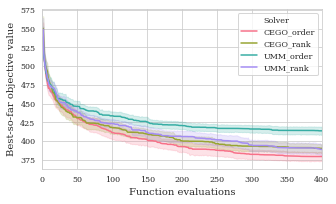

instance:  ARP_10_42
                             Fitness   size
Solver            budget                   
CEGO_order        400     379.294328  12000
CEGO_order_greedy 400     374.883193  12000
GreedyNN          1       391.308150      1
UMM_rank          400     388.701493  12000
UMM_rank_greedy   400     382.399303  12000
Saving to img/greedy_ARP_10_42.pdf


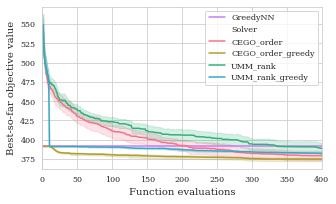

instance:  ARP_10_73
                      Fitness   size
Solver     budget                   
CEGO_order 400     346.026535  12000
CEGO_rank  400     361.038424  12000
UMM_order  400     374.492114  12000
UMM_rank   400     361.423190  12000
Saving to img/rankVorder_ARP_10_73.pdf


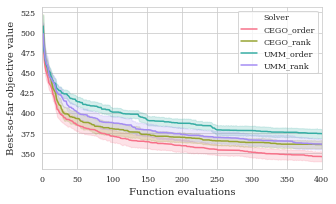

instance:  ARP_10_73
                             Fitness   size
Solver            budget                   
CEGO_order        400     346.026535  12000
CEGO_order_greedy 400     355.888633  12000
GreedyNN          1       398.345460      1
UMM_rank          400     361.423190  12000
UMM_rank_greedy   400     384.958091  12000
Saving to img/greedy_ARP_10_73.pdf


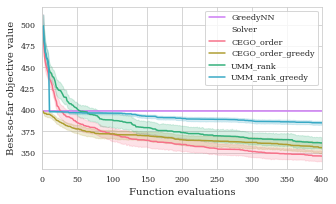

instance:  ARP_15_42
                      Fitness   size
Solver     budget                   
CEGO_order 400     575.069430  12000
CEGO_rank  400     610.100779  12000
UMM_order  400     626.889515  12000
UMM_rank   400     594.618178  12000
Saving to img/rankVorder_ARP_15_42.pdf


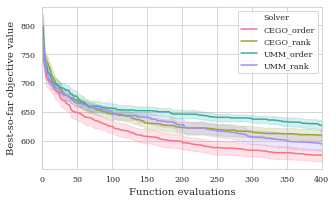

instance:  ARP_15_42
                             Fitness   size
Solver            budget                   
CEGO_order        400     575.069430  12000
CEGO_order_greedy 400     497.186258  12000
GreedyNN          1       508.114739      1
UMM_rank          400     594.618178  12000
UMM_rank_greedy   400     501.722478  12000
Saving to img/greedy_ARP_15_42.pdf


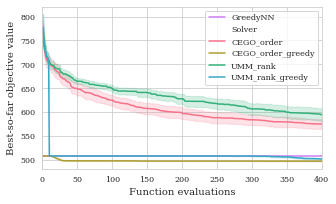

instance:  ARP_15_73
                      Fitness   size
Solver     budget                   
CEGO_order 400     582.442814  12000
CEGO_rank  400     591.589536  12000
UMM_order  400     626.232072  12000
UMM_rank   400     595.251584  12000
Saving to img/rankVorder_ARP_15_73.pdf


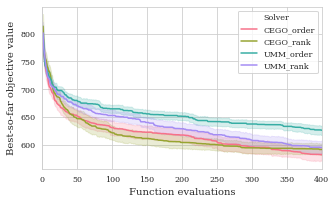

instance:  ARP_15_73
                             Fitness   size
Solver            budget                   
CEGO_order        400     582.442814  12000
CEGO_order_greedy 400     525.627716  12000
GreedyNN          1       576.385205      1
UMM_rank          400     595.251584  12000
UMM_rank_greedy   400     545.025271  12000
Saving to img/greedy_ARP_15_73.pdf


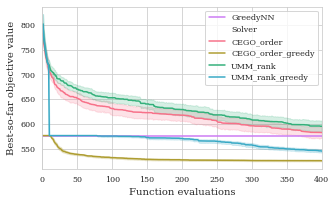

instance:  ARP_20_42
                      Fitness   size
Solver     budget                   
CEGO_order 400     806.206788  12000
CEGO_rank  400     833.154828  12000
UMM_order  400     868.863382  12000
UMM_rank   400     841.611933  12000
Saving to img/rankVorder_ARP_20_42.pdf


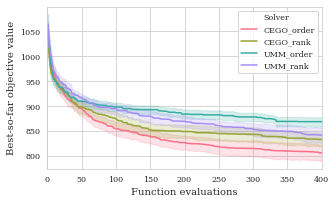

instance:  ARP_20_42
                             Fitness   size
Solver            budget                   
CEGO_order        400     806.206788  12000
CEGO_order_greedy 400     736.988938  12000
GreedyNN          1       841.730182      1
UMM_rank          400     841.611933  12000
UMM_rank_greedy   400     797.585982  12000
Saving to img/greedy_ARP_20_42.pdf


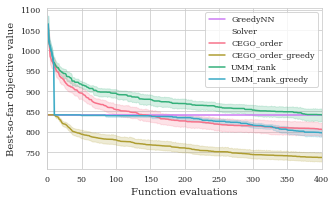

instance:  ARP_20_73
                      Fitness   size
Solver     budget                   
CEGO_order 400     839.196649  12000
CEGO_rank  400     837.987270  12000
UMM_order  400     883.023691  12000
UMM_rank   400     876.752874  12000
Saving to img/rankVorder_ARP_20_73.pdf


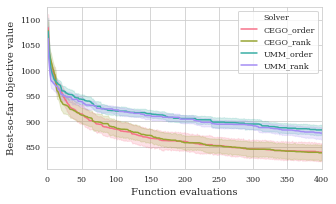

instance:  ARP_20_73
                             Fitness   size
Solver            budget                   
CEGO_order        400     839.196649  12000
CEGO_order_greedy 400     661.756154  12000
GreedyNN          1       691.527286      1
UMM_rank          400     876.752874  12000
UMM_rank_greedy   400     684.692178  12000
Saving to img/greedy_ARP_20_73.pdf


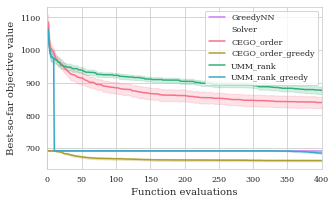

instance:  ARP_25_42
                       Fitness   size
Solver     budget                    
CEGO_order 400     1048.810386  12000
CEGO_rank  400     1074.496882  12000
UMM_order  400     1121.161275  12000
UMM_rank   400     1076.879825  12000
Saving to img/rankVorder_ARP_25_42.pdf


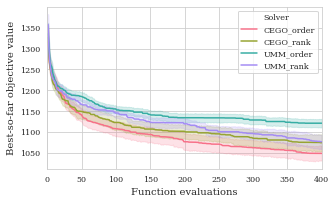

instance:  ARP_25_42
                              Fitness   size
Solver            budget                    
CEGO_order        400     1048.810386  12000
CEGO_order_greedy 400      881.478168  12000
GreedyNN          1        946.253505      1
UMM_rank          400     1076.879825  12000
UMM_rank_greedy   400      921.711510  12000
Saving to img/greedy_ARP_25_42.pdf


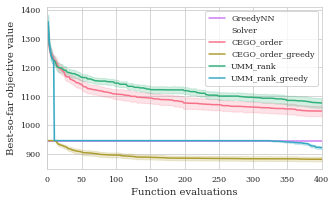

instance:  ARP_25_73
                       Fitness   size
Solver     budget                    
CEGO_order 400     1069.142407  12000
CEGO_rank  400     1096.809712  12000
UMM_order  400     1131.436904  12000
UMM_rank   400     1115.498556  12000
Saving to img/rankVorder_ARP_25_73.pdf


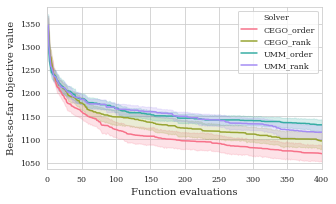

instance:  ARP_25_73
                              Fitness   size
Solver            budget                    
CEGO_order        400     1069.142407  12000
CEGO_order_greedy 400      873.563395  12000
GreedyNN          1        918.314312      1
UMM_rank          400     1115.498556  12000
UMM_rank_greedy   400      911.949529  12000
Saving to img/greedy_ARP_25_73.pdf


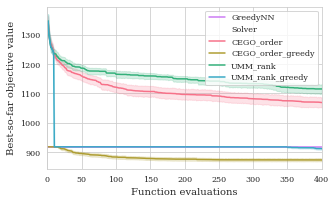

instance:  ARP_30_42
                       Fitness   size
Solver     budget                    
CEGO_order 400     1272.192377  12000
CEGO_rank  400     1334.388993  12000
UMM_order  400     1371.982323  12000
UMM_rank   400     1347.270912  12000
Saving to img/rankVorder_ARP_30_42.pdf


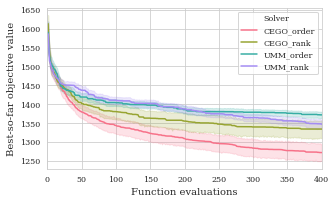

instance:  ARP_30_42
                              Fitness   size
Solver            budget                    
CEGO_order        400     1272.192377  12000
CEGO_order_greedy 400     1084.578310  12000
GreedyNN          1       1131.733318      1
UMM_rank          400     1347.270912  12000
UMM_rank_greedy   400     1115.447943  12000
Saving to img/greedy_ARP_30_42.pdf


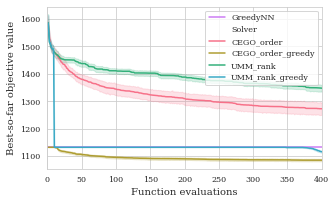

instance:  ARP_30_73
                       Fitness   size
Solver     budget                    
CEGO_order 400     1320.902214  12000
CEGO_rank  400     1325.128375  12000
UMM_order  400     1385.892945  12000
UMM_rank   400     1360.551990  12000
Saving to img/rankVorder_ARP_30_73.pdf


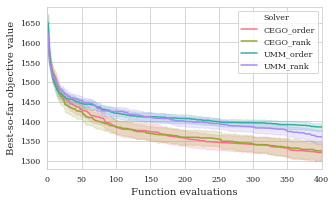

instance:  ARP_30_73
                              Fitness   size
Solver            budget                    
CEGO_order        400     1320.902214  12000
CEGO_order_greedy 400      967.723177  12000
GreedyNN          1       1024.711074      1
UMM_rank          400     1360.551990  12000
UMM_rank_greedy   400     1017.267836  12000
Saving to img/greedy_ARP_30_73.pdf


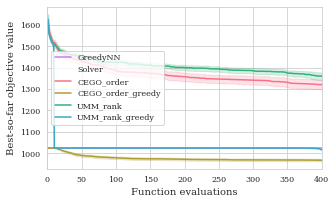

In [5]:
def plot_fitness(df, inst, best = False, prefix = "fitness_"):
    print("instance: ", inst)
    if len(df) == 0: return
    df_fitness = df.groupby(['Solver','budget','seed']).Fitness.min().reset_index()
    df_fitness = df_fitness.pivot_table(index=['Solver','budget'], values='Fitness')
    df_fitness['size'] = df.groupby(['Solver', 'budget'])['Fitness'].size()
    print(df_fitness)
    budget = df.budget.max()
    plt.figure(figsize=get_fig_size("lncs"))
    val_opt = None #get_opt(inst)
    if val_opt is not None: 
        print("optimum: ", val_opt)
        plt.plot([0,budget],[val_opt,val_opt])
    palette = sns.color_palette("husl", df['Solver'].nunique())
    greedynn_f = df.loc[df.Solver.str.startswith("GreedyNN"), ['Solver',"Fitness"]]
    if len(greedynn_f) > 0:
        for index, (solver, fitness) in greedynn_f.iterrows():
            plt.plot([0,budget],[fitness,fitness], label=solver, color=palette.pop())
        df = df[~df.Solver.str.startswith("GreedyNN")]
    if best:
        y_col = 'Best-so-far objective value' 
    else:
        y_col = 'Fitness'
    g = sns.lineplot(x='Function evaluations', y=y_col, hue='Solver', data=df, palette=palette)#, style="eval_ranks")
    g.set(xlim=(0, budget))
    plt.tight_layout()
    filename = 'img/' + prefix + df.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
    print("Saving to " + filename)
    plt.savefig(filename)
    plt.show()  

sel_inst = df.instance.unique()
for inst in sel_inst:
    sel_confs = ['CEGO_order', 'CEGO_rank', 'UMM_order', 'UMM_rank']
    subdf = df[df.instance.str.contains(inst)].sort_values('Solver')
    subdf = subdf[subdf.Solver.isin(sel_confs)]
    plot_fitness(subdf, inst, best = True, prefix = "rankVorder_")
    sel_confs = ['CEGO_order', 'CEGO_order_greedy', 'UMM_rank', 'UMM_rank_greedy', 'GreedyNN']
    subdf = df[df.instance.str.contains(inst)].sort_values('Solver')
    subdf = subdf[subdf.Solver.isin(sel_confs)]
    plot_fitness(subdf, inst, best = True, prefix = "greedy_")

        

## Summary table of the results

Table with the summary of the results

In [6]:
# sel_confs = list(df.Solver.unique())
sel_confs = ['GreedyNN', 'CEGO_order', 'CEGO_order_greedy', 'UMM_rank', 'UMM_rank_greedy']
df = df[df.Solver.isin(sel_confs)]
# The maximum time per seed and evaluation is the final time. 
dftime = df.groupby(['Solver','Instance','seed']).run_time.max().reset_index()
# Then we calculate the mean per instance.
dftime['run_time'] =  (dftime['run_time'] / 60.0)
dftime = dftime.pivot_table(index=['Instance'], columns='Solver',values='run_time').reset_index()
dftime = dftime[['Instance'] + sel_confs]
dftime[sel_confs] = dftime[sel_confs].round(1)
dftime = dftime.sort_values(by='Instance')

print(dftime.to_latex(index=False, caption='Time (minutes)'))

\begin{table}
\centering
\caption{Time (minutes)}
\begin{tabular}{lrrrrr}
\toprule
Instance &  GreedyNN &  CEGO\_order &  CEGO\_order\_greedy &  UMM\_rank &  UMM\_rank\_greedy \\
\midrule
   10\_42 &       0.1 &      2365.4 &             2147.8 &      26.0 &             26.2 \\
   10\_73 &       0.1 &      2372.9 &             2365.3 &      24.2 &             25.7 \\
   15\_42 &       0.1 &      2445.9 &             2394.1 &      34.5 &             32.4 \\
   15\_73 &       0.1 &      2375.6 &             2404.2 &      35.5 &             36.2 \\
   20\_42 &       0.2 &      2411.4 &             2348.4 &      47.8 &             48.7 \\
   20\_73 &       0.2 &      2223.9 &             2387.4 &      48.2 &             50.8 \\
   25\_42 &       0.2 &      2338.1 &             2452.5 &      59.4 &             58.9 \\
   25\_73 &       0.2 &      2397.3 &             2657.6 &      47.3 &             60.3 \\
   30\_42 &       0.2 &      2375.9 &             2553.7 &      61.9 &             6

In [7]:
def mean_std(x):
    mean = x.mean().round(1).astype(str)
    std = x.std().round(1).astype(str)
    return mean + " (" + std + ")"

df_fitness = df.groupby(['Solver', 'Instance','seed']).Fitness.min().reset_index()
# df_fitness = df_fitness.groupby(['Solver','Problem','instance']).Fitness.agg(MeanFitness='mean').reset_index()
df_fitness = df_fitness.pivot_table(index=['Instance'], columns='Solver', values=['Fitness'], aggfunc = mean_std)
df_fitness.columns = df_fitness.columns.droplevel(0)
df_fitness = df_fitness.reset_index()
df_fitness = df_fitness[['Instance'] + sel_confs]
# GreedyNN generates NAN because there is only one run per instance.
df_fitness = df_fitness.sort_values(by='Instance')
print(df_fitness.to_latex(index=False, caption="Mean fitness"))

\begin{table}
\centering
\caption{Mean fitness}
\begin{tabular}{llllll}
\toprule
Instance &     GreedyNN &    CEGO\_order & CEGO\_order\_greedy &      UMM\_rank & UMM\_rank\_greedy \\
\midrule
   10\_42 &  391.3 (nan) &  379.3 (17.5) &       374.9 (6.9) &  388.7 (20.8) &     382.4 (1.1) \\
   10\_73 &  398.3 (nan) &  346.0 (17.7) &      355.9 (18.3) &  361.4 (18.9) &     385.0 (6.4) \\
   15\_42 &  508.1 (nan) &  575.1 (29.2) &       497.2 (1.1) &  594.6 (37.7) &     501.7 (3.8) \\
   15\_73 &  576.4 (nan) &  582.4 (33.1) &       525.6 (4.7) &  595.3 (32.6) &     545.0 (9.3) \\
   20\_42 &  841.7 (nan) &  806.2 (45.2) &      737.0 (31.0) &  841.6 (43.7) &    797.6 (28.3) \\
   20\_73 &  691.5 (nan) &  839.2 (49.8) &       661.8 (7.8) &  876.8 (32.7) &     684.7 (6.1) \\
   25\_42 &  946.3 (nan) & 1048.8 (51.2) &      881.5 (23.3) & 1076.9 (48.5) &    921.7 (15.2) \\
   25\_73 &  918.3 (nan) & 1069.1 (49.5) &      873.6 (15.3) & 1115.5 (45.5) &    911.9 (10.0) \\
   30\_42 & 1131.7 (nan